In [9]:
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange
from models.mae import MAE_Encoder
from models.vae import DeepVAE
from models.ldm import UNet
import random


In [ ]:
def data_normalize(scale, data):
    min_val = data.min()
    max_val = data.max()
    return scale * (data - min_val) / (max_val - min_val)


np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# V0_tensor = torch.tensor(np.load('Data/V/V_EIM0_64.npy'))
V1_tensor = torch.tensor(np.load('./data/V/V_EIM1_64.npy'))
V2_tensor = torch.tensor(np.load('./data/V/V_EIM2_64.npy'))
V3_tensor = torch.tensor(np.load('./data/V/V_EIM3_64.npy'))
V4_tensor = torch.tensor(np.load('./data/V/V_EIM4_64.npy'))
V5_tensor = torch.tensor(np.load('./data/V/V_EIM5_64.npy'))

# GT0_tensor = torch.tensor(np.load('Data/GT/GT0.npy'))
GT1_tensor = torch.tensor(np.load('./data/GT/GT1.npy'))
GT2_tensor = torch.tensor(np.load('./data/GT/GT2.npy'))
GT3_tensor = torch.tensor(np.load('./data/GT/GT3.npy'))
GT4_tensor = torch.tensor(np.load('./data/GT/GT4.npy'))
GT5_tensor = torch.tensor(np.load('./data/GT/GT5.npy'))

'''500*5 data'''
V_train = torch.cat((
        V1_tensor[0:500]
        ,V2_tensor[0:500]
        ,V3_tensor[0:500]
        ,V4_tensor[0:500]
        # ,V5_tensor[0:500]
    ), dim=0)
V_val = torch.cat((V1_tensor[-1500:-500]
                    , V2_tensor[-1500:-500]
                    , V3_tensor[-1500:-500]
                    , V4_tensor[-1500:-500]
                    , V5_tensor[-1500:-500]
                    ), dim=0)
V_test = torch.cat((V1_tensor[-500:]
                    , V2_tensor[-500:]
                    , V3_tensor[-500:]
                    , V4_tensor[-500:]
                    , V5_tensor[-500:]
                    ), dim=0)
GT_train = torch.cat((GT1_tensor[0:500]
                        , GT2_tensor[0:500]
                        , GT3_tensor[0:500]
                        , GT4_tensor[0:500]
                        , GT5_tensor[0:500]
                        ), dim=0)
GT_val = torch.cat((GT1_tensor[-1500:-500]
                    , GT2_tensor[-1500:-500]
                    , GT3_tensor[-1500:-500]
                    , GT4_tensor[-1500:-500]
                    , GT5_tensor[-1500:-500]
                    ), dim=0)
GT_test = torch.cat((GT1_tensor[-500:]
                    , GT2_tensor[-500:]
                    , GT3_tensor[-500:]
                    , GT4_tensor[-500:]
                    , GT5_tensor[-500:]
                    ), dim=0)

GT_train = data_normalize(scale=1, data=GT_train)
GT_val = data_normalize(scale=1, data=GT_val)
GT_test = data_normalize(scale=1, data=GT_test)

# randomly shuffle the training data
indices = np.arange(len(V_train))
np.random.shuffle(indices)

# apply the shuffled indices to V_train and GT_train
V_train = V_train[indices]
GT_train = GT_train[indices]
print(V_train.shape)
print(GT_train.shape)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch.Size([2000, 1, 64, 64])
torch.Size([2000, 1, 48, 48])


In [ ]:
def add_noise(features, noise, noise_step, betas):
    alpha_cumprod = torch.cumprod(1 - betas, dim=0)
    sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod)
    sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - alpha_cumprod)

    alpha_t = sqrt_alpha_cumprod[noise_step].view(-1, 1, 1, 1)
    one_minus_alpha_t = sqrt_one_minus_alpha_cumprod[noise_step].view(-1, 1, 1, 1)
    
    return alpha_t * features + one_minus_alpha_t * noise

def get_loss(x, y, encoder, vae, unet, criterion, device, epoch, batch_size, betas):
    if epoch < 0:
        raise ValueError("Epoch must be non-negative")
    # extract features from the MAE encoder
    features, backward_indexes = encoder(x)
    # [65, b, 128] -> [b, 65, 128]
    out_encoder = rearrange(features, 't b c -> b t c')

    out_vae = vae.encoder(y)
    #0.18215 = vae.config.scaling_factor
    out_vae = out_vae * 0.18215
    
    # random number, the calculate target 
    noise = torch.randn_like(out_vae)

    # add noise to the VAE output
    #1000 = scheduler.num_train_timesteps
    #1 = batch size
    noise_step = torch.randint(0, len(betas), (out_vae.size(0), )).long().to(device)
    # noise_step = torch.randint(0, 1000, (1, )).long().to(device)
    out_vae_noise = add_noise(out_vae, noise, noise_step, betas)

    # Calculate the noise in the feature map based on the voltage information
    out_unet = unet(out_vae=out_vae_noise,
                    out_encoder=out_encoder,
                    time=noise_step)
    # Calculate mse loss
    #[1, 128, 6, 6],[1, 128, 6, 6]
    # Compare the calculated noise with the real noise
    return criterion(out_unet, noise), out_unet

def get_img_loss(x, y, encoder, vae, unet, criterion, device, epoch, batch_size, betas):
    if epoch < 0:
        raise ValueError("Epoch must be non-negative")
    
    features, backward_indexes = encoder(x)
    out_encoder = rearrange(features, 't b c -> b t c')
    out_vae = vae.encoder(y)
    # Generate **pure noise**
    noise = torch.randn_like(out_vae)
    # print('noise shape:', out_vae.shape)[8, 128, 6, 6]
    # Get random noise step
    noise_step = torch.randint(0, len(betas), (out_vae.size(0), )).long().to(device)
    # Add noise to the VAE output
    out_vae_noise = add_noise(out_vae, noise, noise_step, betas)
    # Pass through the UNet
    out_unet = unet(out_vae=out_vae_noise,
                    out_encoder=out_encoder,
                    time=noise_step)
    # Decode the output
    out_img = vae.decoder(out_unet)

    return criterion(out_img, y), out_img

In [12]:
import torch
import numpy as np
import torch.nn as nn

def test_get_loss():
    # Set random seed for reproducibility
    set_seed(1024)

    # Define device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the models
    encoder = MAE_Encoder().to(device)
    vae = DeepVAE().to(device)
    unet = UNet().to(device)

    # Load pre-trained model weights
    encoder.load_state_dict(torch.load('./results/Model/V_pretrain/MAE_img64_encoder_mr0.75_eb256_data492500.pth'), strict=False)
    vae.load_state_dict(torch.load('./results/Model/GT_pretrain/GT_DeepVAE_2000_MSE.pth'), strict=False)
    unet.load_state_dict(torch.load('./results/Model/Finetune/ldm_2500data.pth'), strict=False)

    # Freeze encoder and VAE parameters
    encoder.eval()
    vae.eval()
    unet.eval()
    for param in encoder.parameters():
        param.requires_grad = False
    for param in vae.parameters():
        param.requires_grad = False
    for param in unet.parameters():
        param.requires_grad = False

    # Initialize betas for the diffusion process
    beta_start = 0.00085
    beta_end = 0.012
    num_timesteps = 1000
    betas = (
        torch.linspace(
            beta_start ** 0.5,
            beta_end ** 0.5,
            num_timesteps,
            dtype=torch.float32
        ) ** 2
    ).to(device)

    # Define the criterion (loss function)
    criterion = nn.MSELoss()

    # Run the test
    unet.train()  # Set UNet to training mode
    epoch = 0  # You can vary this to test different epochs
    batch_size = 10  # This is the size of the small batch we're testing

    # Initialize an empty list to store outputs
    all_outputs = []

    # Compute the loss
    loss, output = get_img_loss(
        x=V_test.to(device),
        y=GT_test.to(device),
        encoder=encoder,
        vae=vae,
        unet=unet,
        criterion=criterion,
        device=device,
        epoch=epoch,
        batch_size=batch_size,
        betas=betas
    )

    print(f'Test loss: {loss.item()}, Output shape: {output.shape}')

    # Additional checks (assertions)
    assert loss.item() >= 0, "Loss should be non-negative."
    print("Test passed successfully.")
    
    # Append and concatenate outputs
    all_outputs.append(output.cpu())  # Move output to CPU and store
    all_outputs = torch.cat(all_outputs, dim=0)  # Concatenate along the 0th dimension
    
    return all_outputs  # Optionally return the concatenated outputs

if __name__ == '__main__':
    all_outputs = test_get_loss()


Test loss: 0.0051500918343663216, Output shape: torch.Size([2500, 1, 48, 48])
Test passed successfully.


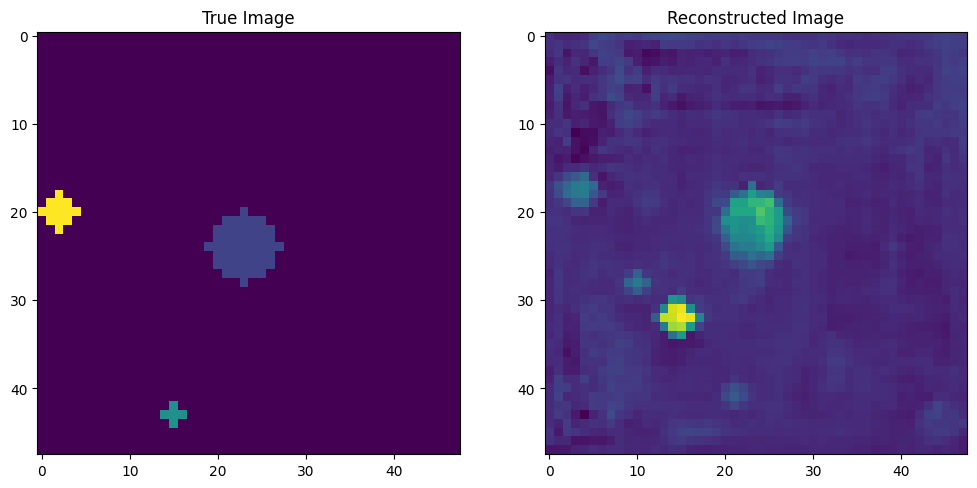

<Figure size 640x480 with 0 Axes>

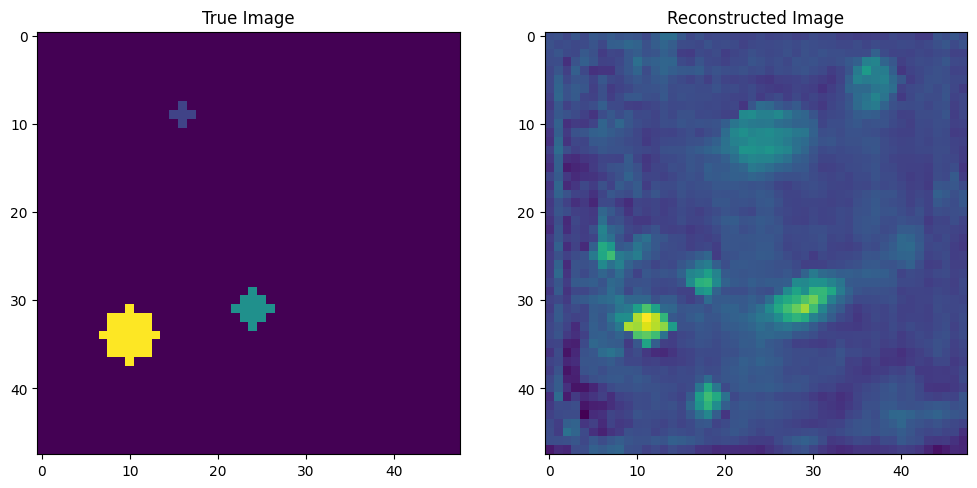

<Figure size 640x480 with 0 Axes>

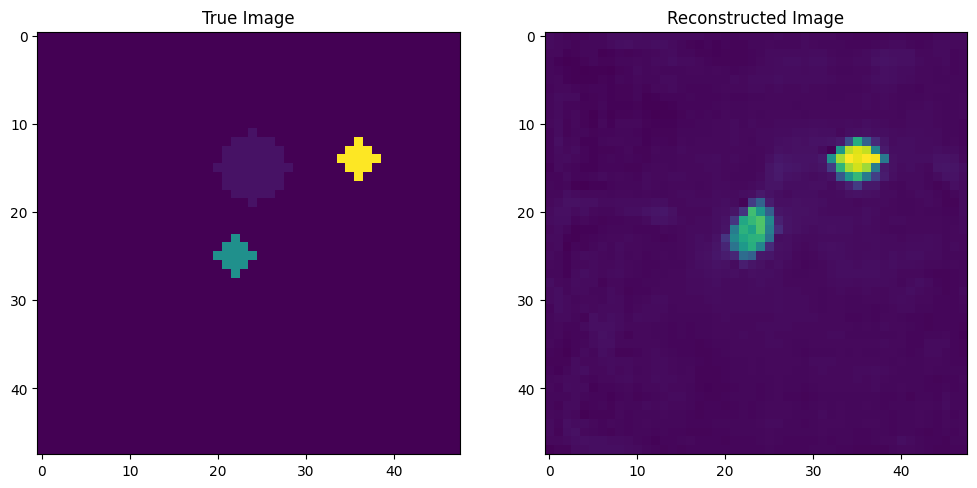

<Figure size 640x480 with 0 Axes>

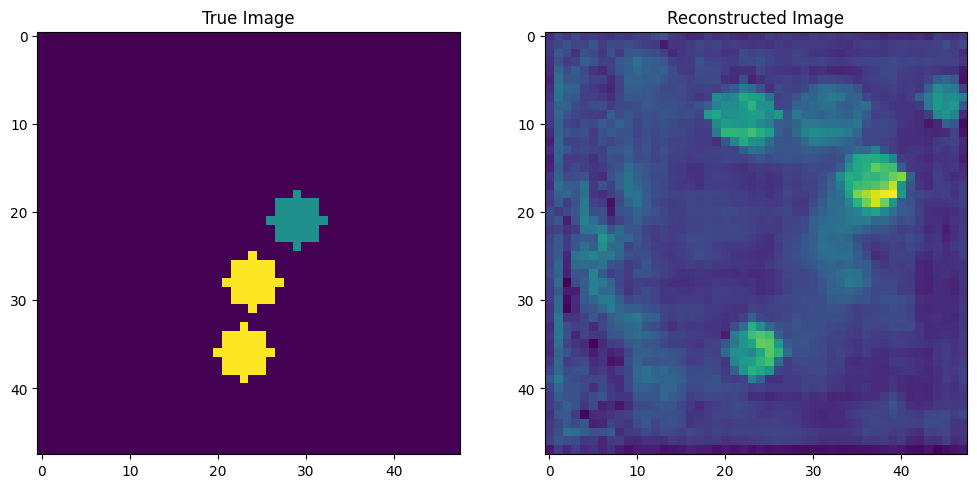

<Figure size 640x480 with 0 Axes>

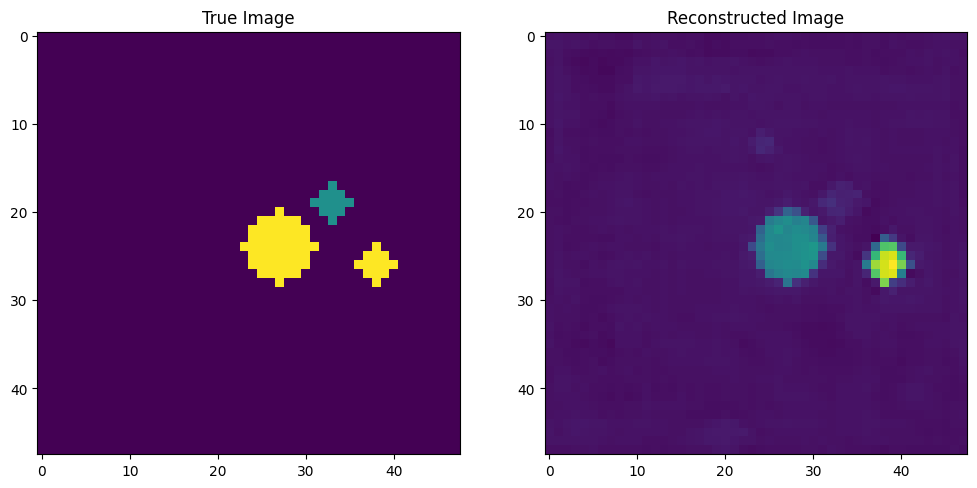

<Figure size 640x480 with 0 Axes>

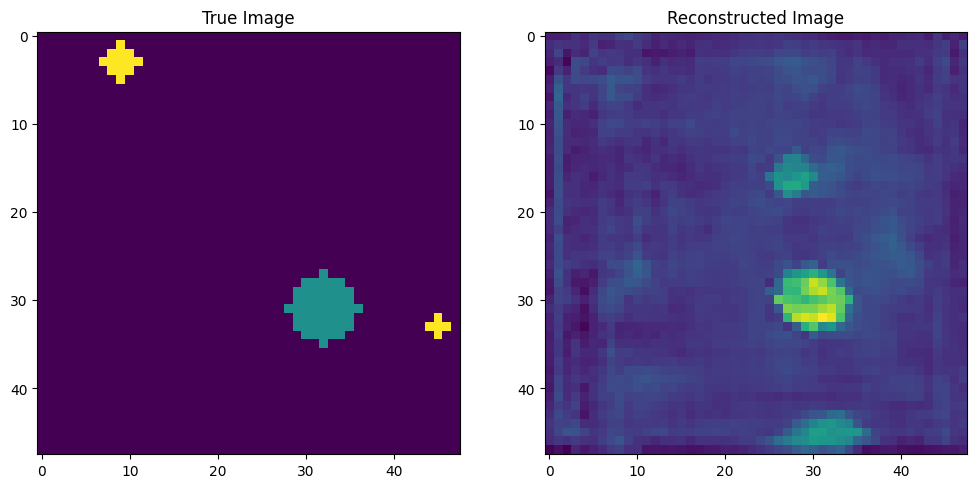

<Figure size 640x480 with 0 Axes>

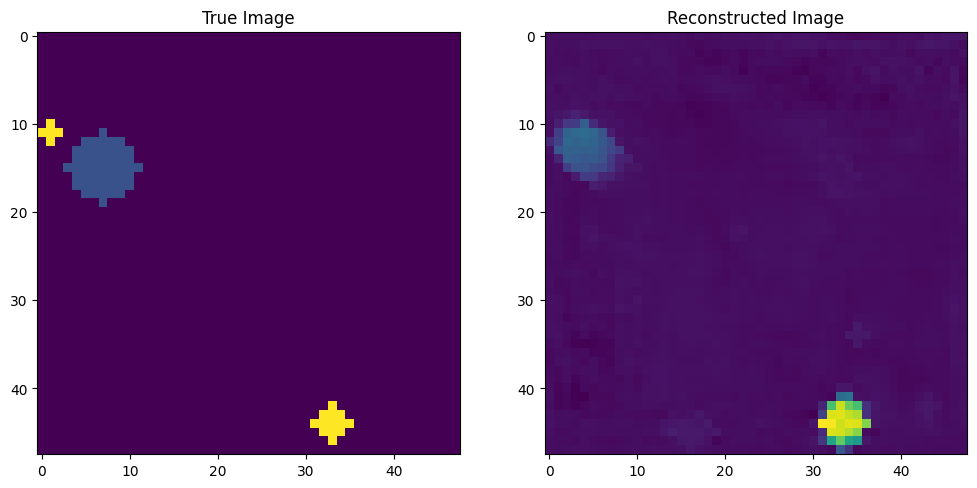

<Figure size 640x480 with 0 Axes>

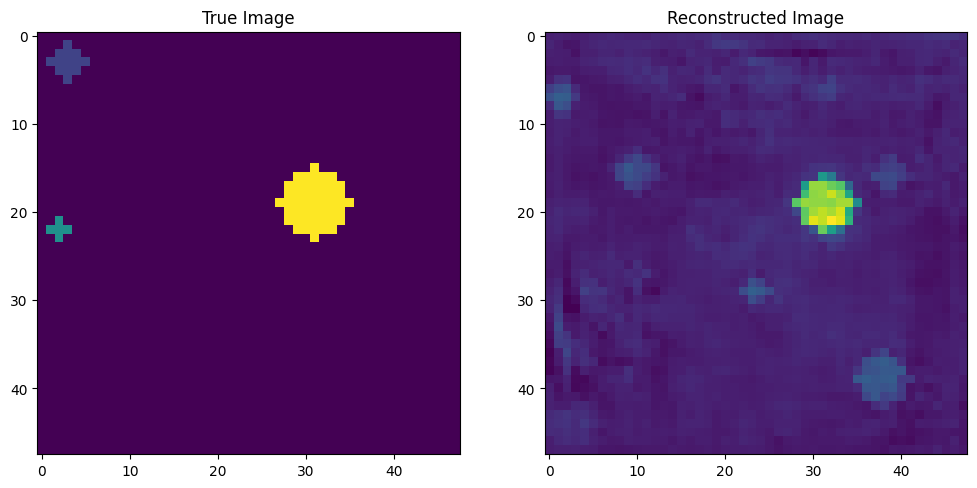

<Figure size 640x480 with 0 Axes>

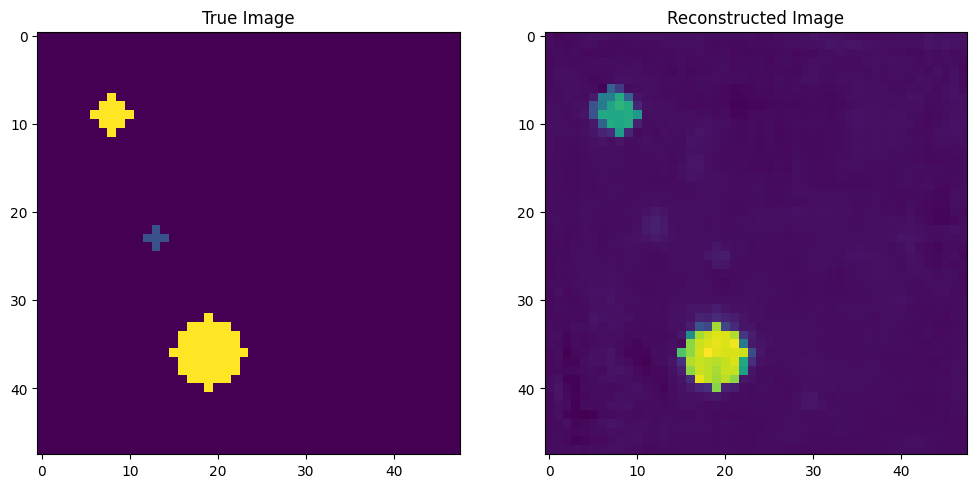

<Figure size 640x480 with 0 Axes>

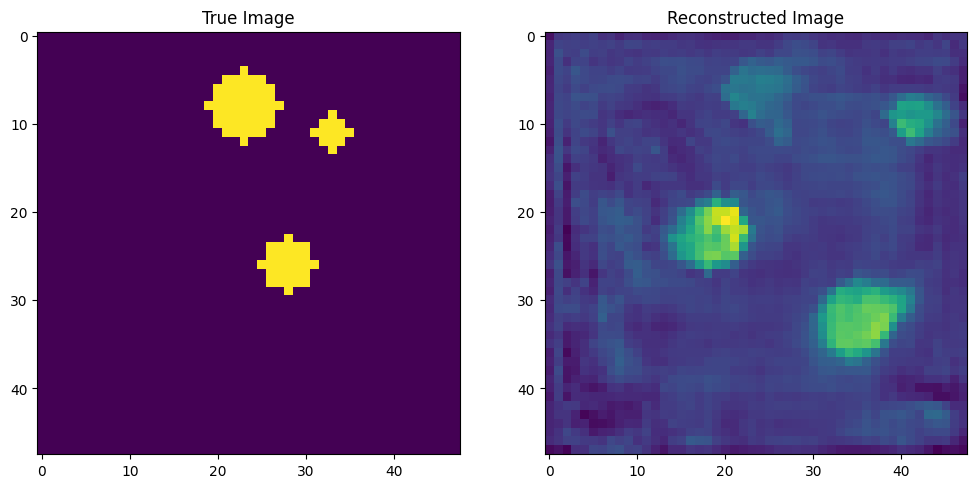

<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import time

# Assume you have already obtained the model's output `all_outputs` and the ground truth labels `GT_test`.
# `all_outputs` is the output from the model.
# `GT_test` is the corresponding ground truth label.

# To numpy and flatten the outputs and labels
all_outputs = all_outputs.cpu().detach().numpy().reshape(-1, GT_test.shape[2], GT_test.shape[3])
GT_test = GT_test.cpu().detach().numpy().reshape(-1, GT_test.shape[2], GT_test.shape[3])


# np.savetxt('Result/Pre_FCNN_square.txt', all_outputs.reshape(2500, -1), fmt='%f')
# np.savetxt('Result/Label_FCNN_square.txt', GT_test.reshape(2500, -1), fmt='%f')

N = 1200  # start from the Nth image
for idx in range(N, N + 10):
    Prediction = all_outputs[idx]
    Label_test = GT_test[idx]

    # 绘制真实图像和重构图像
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(Label_test, norm=Normalize())
    plt.title('True Image')
    # plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(Prediction, norm=Normalize())
    plt.title('Reconstructed Image')
    # plt.colorbar()
    plt.show()

    # add a short pause to allow each frame to be displayed
    time.sleep(0.1)

    # Clear the current plot to avoid overlap
    plt.clf()
